# Task 5:


#### In this task I tried to adapt the implementation on the PennyLane tutorial on Quanvolutional Neural Networks by Andrea Mari (Published March 24, 2020. Last updated August 5, 2024).  Ref: https://pennylane.ai/qml/demos/tutorial_quanvolution/


#### I tried to read the data file from the dataset given in Kaggle, load and preprocess the images in the data. Then I set up the parameters for the model. I was experimenting with different datasets usage:
First: 

n_epochs = 40   # Number of optimization epochs

n_layers = 1    # Number of random layers

n_train = 1000    # Size of the train dataset

n_test = 600   

second:

n_epochs = 30   # Number of optimization epochs

n_layers = 1    # Number of random layers

n_train = 500    # Size of the train dataset

n_test = 300   

As shown in the images below, the results indicated that increasing the size of the training dataset led to a decrease in accuracy. This could be due to several factors, such as the limitations of the available qubits for implementing the quantum circuit or the need for additional data preprocessing.

Another significant challenge I encountered was the limited computing power. Since I do not have access to a GPU, I experienced difficulties in testing my model efficiently on my PC, which could have affected the results.


In [136]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
from PIL import Image
import numpy as np
import os


# Data Preprocessing

In [3]:
import json
from PIL import Image
import numpy as np
import os

def load_images_and_labels(base_directory, json_file):
    # Load the labels from the JSON file
    json_path = os.path.join(base_directory, json_file)
    with open(json_path, 'r') as file:
        labels_dict = json.load(file)

    data = []
    labels = []

    # Iterate over each entry in the labels dictionary
    for image_path, label in labels_dict.items():
        full_image_path = os.path.join(base_directory, image_path)
        if os.path.exists(full_image_path):
            img = Image.open(full_image_path).convert('L')  # Convert image to grayscale
            img = img.resize((16, 16))  # Resize image to fit quantum circuit input
            img_array = np.array(img) / 255.0  # Normalize pixel values
            data.append(img_array.flatten())  # Flatten the image data for quantum processing
            labels.append(label)  # Append corresponding label
        else:
            print(f"Warning: {full_image_path} not found.")

    return np.array(data), np.array(labels)


In [4]:
train_dir = 'datasets/train/'
test_dir = 'datasets/test/'


X_train, y_train = load_images_and_labels(train_dir, 'train.json')
X_test, y_test = load_images_and_labels(test_dir, 'test.json')


In [48]:
!pip install keras==2.11.0


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 187.9 kB/s eta 0:00:09
    --------------------------------------- 0.0/1.7 MB 187.9 kB/s eta 0:00:09
    --------------------------------------- 0.0/1.7 MB 140.3 kB/s eta 0:00:12
   - -------------------------------------- 0.1/1.7 MB 270.5 kB/s eta 0:00:06
   - -------------------------------------- 0.1/1.7 MB 270.5 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.7 MB 312.2 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.7 MB 312.2 kB/s eta 0:00:06
   ---- -----------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.17.0 requires keras>=3.2.0, but you have keras 2.11.0 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [134]:
X_train_images = X_train_images.reshape(-1, 16, 16, 1)
X_test_images = X_test_images.reshape(-1, 16, 16, 1)

In [120]:
n_epochs = 40   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 1000    # Size of the train dataset
n_test = 600     # Size of the test dataset

In [121]:
X_train_images = X_train[:n_train]
y_train_images = y_train[:n_train]
X_test_images = X_test[:n_test]
y_test_images = y_test[:n_test]
# train_labels = train_labels[:n_train]
# test_images = test_images[:n_test]
# test_labels = test_labels[:n_test]


# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_val = np.array(X_val)
# y_val = np.array(y_val)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

In [122]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [123]:


def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((8, 8, 4))  # Assuming 16x16 input, the output will be 8x8
    for j in range(0, 16, 2):  # Adjusted to match 16x16 input
        for k in range(0, 16, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]

    return out


In [124]:
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)
from pennylane.templates import RandomLayers

SAVE_PATH = "datasets/quanvolution/"  # Data saving folder

In [125]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(X_train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(X_test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


Quantum pre-processing of train images:
1000/1000        
Quantum pre-processing of test images:


In [126]:
import pennylane as qml
from pennylane import numpy as np

from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [127]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [128]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    y_train_images,
    validation_data=(q_test_images, y_test_images),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/40
250/250 - 2s - 8ms/step - accuracy: 0.4590 - loss: 1.4296 - val_accuracy: 0.1767 - val_loss: 1.7215
Epoch 2/40
250/250 - 1s - 3ms/step - accuracy: 0.6950 - loss: 1.0472 - val_accuracy: 0.0500 - val_loss: 1.5867
Epoch 3/40
250/250 - 1s - 3ms/step - accuracy: 0.7600 - loss: 0.8707 - val_accuracy: 0.1583 - val_loss: 1.5276
Epoch 4/40
250/250 - 1s - 3ms/step - accuracy: 0.7840 - loss: 0.7631 - val_accuracy: 0.2700 - val_loss: 1.4994
Epoch 5/40
250/250 - 1s - 3ms/step - accuracy: 0.8000 - loss: 0.6902 - val_accuracy: 0.3383 - val_loss: 1.4887
Epoch 6/40
250/250 - 1s - 3ms/step - accuracy: 0.8100 - loss: 0.6374 - val_accuracy: 0.3967 - val_loss: 1.4891
Epoch 7/40
250/250 - 1s - 5ms/step - accuracy: 0.8140 - loss: 0.5973 - val_accuracy: 0.4333 - val_loss: 1.4968
Epoch 8/40
250/250 - 1s - 3ms/step - accuracy: 0.8200 - loss: 0.5654 - val_accuracy: 0.4550 - val_loss: 1.5096
Epoch 9/40
250/250 - 1s - 3ms/step - accuracy: 0.8210 - loss: 0.5394 - val_accuracy: 0.4733 - val_loss: 1.5257
E

In [129]:
c_model = MyModel()

c_history = c_model.fit(
    X_train_images,
    y_train_images,
    validation_data=(X_test_images, y_test_images),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/40
250/250 - 2s - 8ms/step - accuracy: 0.3620 - loss: 1.6505 - val_accuracy: 0.0000e+00 - val_loss: 2.0843
Epoch 2/40
250/250 - 1s - 3ms/step - accuracy: 0.4060 - loss: 1.4600 - val_accuracy: 0.0000e+00 - val_loss: 2.0027
Epoch 3/40
250/250 - 1s - 2ms/step - accuracy: 0.4800 - loss: 1.3356 - val_accuracy: 0.0000e+00 - val_loss: 1.9350
Epoch 4/40
250/250 - 1s - 2ms/step - accuracy: 0.5680 - loss: 1.2346 - val_accuracy: 0.0000e+00 - val_loss: 1.8773
Epoch 5/40
250/250 - 1s - 3ms/step - accuracy: 0.6300 - loss: 1.1513 - val_accuracy: 0.0050 - val_loss: 1.8278
Epoch 6/40
250/250 - 1s - 3ms/step - accuracy: 0.6830 - loss: 1.0817 - val_accuracy: 0.0083 - val_loss: 1.7852
Epoch 7/40
250/250 - 1s - 2ms/step - accuracy: 0.7150 - loss: 1.0228 - val_accuracy: 0.0167 - val_loss: 1.7486
Epoch 8/40
250/250 - 1s - 3ms/step - accuracy: 0.7260 - loss: 0.9724 - val_accuracy: 0.0283 - val_loss: 1.7170
Epoch 9/40
250/250 - 1s - 3ms/step - accuracy: 0.7420 - loss: 0.9287 - val_accuracy: 0.0450 - va

C:\Users\Galane-Basha\AppData\Local\Temp\ipykernel_25504\4234478001.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


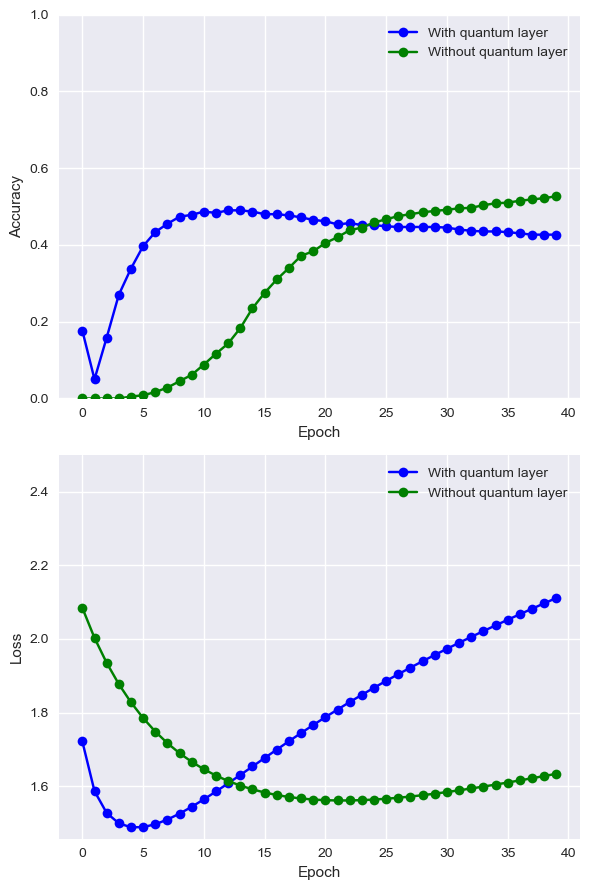

In [130]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


# The following result is with 500 training and 300 test dataset

C:\Users\Galane-Basha\AppData\Local\Temp\ipykernel_25504\4234478001.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


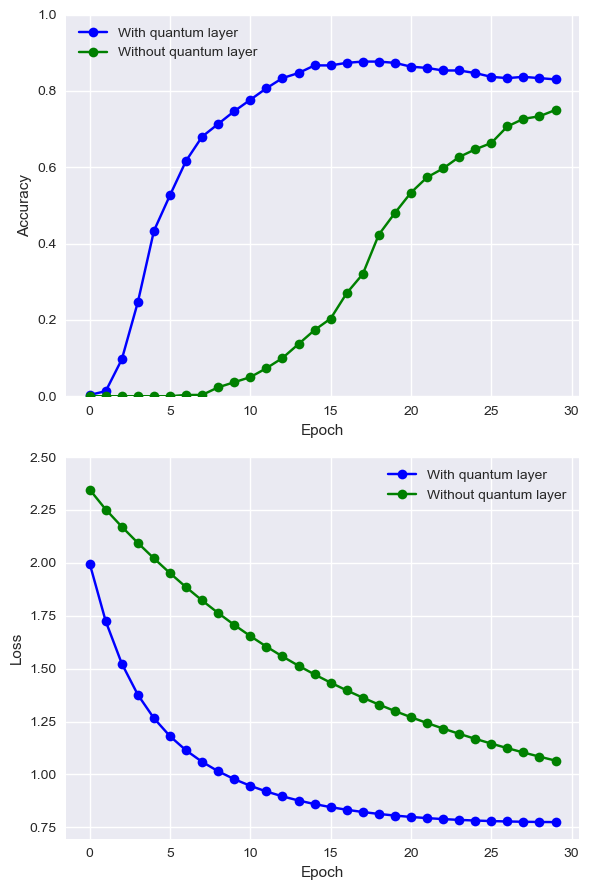

In [108]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
